In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [4]:
dataset = load_boston()
dataset  # 是一个字典
dataset.target  # 查看数据标签
dataset.data  # 数据的特征矩阵
dataset.data.shape  # 数据的结构
# 总共506*13=6578个数据
X_full, y_full = dataset.data, dataset.target
n_samples = X_full.shape[0]
n_features = X_full.shape[1]

In [11]:
# 首先确定我们希望放入的缺失数据的比例，在这里我们假设是50%，那总共就要有3289个数据缺失
rng = np.random.RandomState(0)  # 设置一个随机种子，方便观察
missing_rate = 0.5
n_missing_samples = int(np.floor(n_samples * n_features * missing_rate)) # 3289
#np.floor向下取整，返回.0格式的浮点数
 
#所有数据要随机遍布在数据集的各行各列当中，而一个缺失的数据会需要一个行索引和一个列索引
#如果能够创造一个数组，包含3289个分布在0~506中间的行索引，和3289个分布在0~13之间的列索引，那我们就可以利用索引来为数据中的任意3289个位置赋空值
#然后我们用0，均值和随机森林来填写这些缺失值，然后查看回归的结果如何
missing_features = rng.randint(0, n_features, n_missing_samples)
len(missing_features)
missing_samples = rng.randint(0, n_samples, n_missing_samples)
len(missing_samples)
#missing_samples = rng.choice(n_samples,n_missing_samples,replace=False)
#我们现在采样了3289个数据，远远超过我们的样本量506，所以我们使用随机抽取的函数randint。
# 但如果我们需要的数据量小于我们的样本量506，那我们可以采用np.random.choice来抽样，choice会随机抽取不重复的随机数，
# 因此可以帮助我们让数据更加分散，确保数据不会集中在一些行中!
#这里我们不采用np.random.choice,因为我们现在采样了3289个数据，远远超过我们的样本量506，使用np.random.choice会报错
 
X_missing = X_full.copy()
y_missing = y_full.copy()

X_missing[missing_samples, missing_features] = np.nan
X_missing = pd.DataFrame(X_missing)
print(X_missing.isnull().sum().sum())
#转换成DataFrame是为了后续方便各种操作，numpy对矩阵的运算速度快到拯救人生，但是在索引等功能上却不如pandas来得好用
X_missing.head()

#并没有对y_missing进行缺失值填补，原因是有监督学习，不能缺标签啊

2589


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,18.0,NaN,NaN,0.538,NaN,65.2,4.0900,1.0,296.0,NaN,NaN,4.98
1,0.02731,0.0,NaN,0.0,0.469,NaN,78.9,4.9671,2.0,NaN,NaN,396.9,9.14
2,0.02729,NaN,7.07,0.0,NaN,7.185,61.1,NaN,2.0,242.0,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,0.458,NaN,45.8,NaN,NaN,222.0,18.7,NaN,NaN
4,NaN,0.0,2.18,0.0,NaN,7.147,NaN,NaN,NaN,NaN,18.7,NaN,5.33


In [12]:
# 使用均值进行填补
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')  # 实例化
X_missing_mean = imp_mean.fit_transform(X_missing)
#特殊的接口fit_transform = 训练fit + 导出predict
# pd.DataFrame(X_missing_mean).isnull()#但是数据量大的时候还是看不全
# 布尔值False = 0， True = 1
# pd.DataFrame(X_missing_mean).isnull().sum()#如果求和为0可以彻底确认是否有NaN

# 使用0进行填补
# 使用0进行填补
imp_0 = SimpleImputer(missing_values=np.nan,
                      strategy="constant", fill_value=0)  # constant指的是常数
X_missing_0 = imp_0.fit_transform(X_missing)

In [25]:
X_missing_reg = X_missing.copy()
# 找出数据集中，缺失值从小到大排列的特征们的顺序，并且有了这些的索引
sortindex = np.argsort(X_missing_reg.isnull().sum(
    axis=0)).values  # np.argsort()返回的是从小到大排序的顺序所对应的索引

for i in sortindex:
    # 构建我们的新特征矩阵（没有被选中去填充的特征 + 原始的标签）和新标签（被选中去填充的特征）
    df = X_missing_reg
    fillc = df.iloc[:, i]  # 新标签
    df = pd.concat([df.iloc[:, df.columns != i],
                    pd.DataFrame(y_full)], axis=1)  # 新特征矩阵

    # 在新特征矩阵中，对含有缺失值的列，进行0的填补
    df_0 = SimpleImputer(missing_values=np.nan,
                         strategy='constant', fill_value=0).fit_transform(df)

    # 找出我们的训练集和测试集
    Ytrain = fillc[fillc.notnull()]  # Ytrain是被选中要填充的特征中（现在是我们的标签），存在的那些值：非空值
    # Ytest 是被选中要填充的特征中（现在是我们的标签），不存在的那些值：空值。注意我们需要的不是Ytest的值，需要的是Ytest所带的索引
    Ytest = fillc[fillc.isnull()]
    Xtrain = df_0[Ytrain.index, :]  # 在新特征矩阵上，被选出来的要填充的特征的非空值所对应的记录
    Xtest = df_0[Ytest.index, :]  # 在新特征矩阵上，被选出来的要填充的特征的空值所对应的记录

    # 用随机森林回归来填补缺失值
    rfc = RandomForestRegressor(n_estimators=100)  # 实例化
    rfc = rfc.fit(Xtrain, Ytrain)  # 导入训练集进行训练
    # 用predict接口将Xtest导入，得到我们的预测结果（回归结果），就是我们要用来填补空值的这些值
    Ypredict = rfc.predict(Xtest)

    # 将填补好的特征返回到我们的原始的特征矩阵中
    X_missing_reg.loc[X_missing_reg.iloc[:, i].isnull(), i] = Ypredict

# 检验是否有空值
X_missing_reg.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [27]:
# 对所有数据进行建模，取得MSE结果

X = [X_full, X_missing_mean, X_missing_0, X_missing_reg]

mse = []
std = []
for x in X:
    estimator = RandomForestRegressor(random_state=0, n_estimators=100)
    scores = cross_val_score(estimator, x, y_full,
                             scoring='neg_mean_squared_error', cv=5).mean()
    mse.append(scores * -1)

In [28]:
[*zip(['Full data','Zero Imputation','Mean Imputation','Regressor Imputation'],mse)]

[('Full data', 21.571667100368845),
 ('Zero Imputation', 40.848037216676374),
 ('Mean Imputation', 49.626793201980185),
 ('Regressor Imputation', 17.53516558361482)]

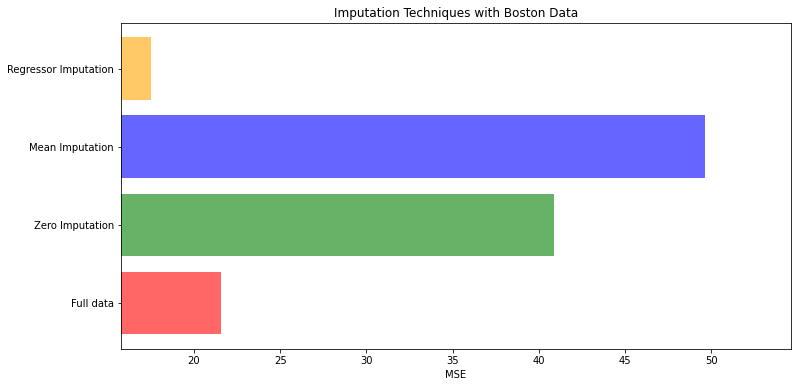

In [29]:
x_labels = ['Full data',
            'Zero Imputation',
            'Mean Imputation',
            'Regressor Imputation']
colors = ['r', 'g', 'b', 'orange']

plt.figure(figsize=(12, 6))  # 画出画布
ax = plt.subplot(111)  # 添加子图
for i in np.arange(len(mse)):
    # bar为条形图，barh为横向条形图，alpha表示条的粗度
    ax.barh(i, mse[i], color=colors[i], alpha=0.6, align='center')
ax.set_title('Imputation Techniques with Boston Data')
ax.set_xlim(left=np.min(mse) * 0.9,
            right=np.max(mse) * 1.1)  # 设置x轴取值范围
ax.set_yticks(np.arange(len(mse)))
ax.set_xlabel('MSE')
ax.set_yticklabels(x_labels)
plt.show()